In [ ]:
#Image loading and preprocessing.
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Set the image size and folders
image_size = (256, 256)
image_folder = 'Augmented_Images'
processed_images = []

# Loop through and preprocess images
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(image_folder, filename)
        with Image.open(img_path) as img:
            # Ensure the image is in RGB format (3 channels)
            img = img.convert("RGB")
            # Resize the image to the specified size
            img_resized = img.resize(image_size)
            # Convert the image to a numpy array and normalize to [0, 1]
            img_array = np.array(img_resized) / 127.5 - 1
            processed_images.append(img_array)
            
            

# Convert list to numpy array for model training
processed_images = np.array(processed_images)
print(f"Processed images shape: {processed_images.shape}")


Processed images shape: (144, 256, 256, 3)


In [ ]:
# label loading and processing
import json
import os

# Folder containing JSON files
json_folder = 'Augmented_Labels'
text_descriptions = []
feature_vectors = []

# Function to generate a description and feature vector
def create_description_and_features(data):
    # Initialize room count dictionary
    room_counts = {
        "bedroom": 0,
        "kitchen": 0,
        "toilet": 0,
        "hall": 0,
        "balcony": 0
    }

    # Count occurrences of each room type
    for shape in data.get("shapes", []):
        label = shape.get("label", "").strip().lower()
        if label in room_counts:
            room_counts[label] += 1

    # Create a structured text description
    description = f"{room_counts['bedroom']}BHK floor plan"
    if room_counts['toilet'] > 0:
        description += f" with {room_counts['toilet']} bathroom{'s' if room_counts['toilet'] > 1 else ''}"
    if room_counts['hall'] > 0:
        description += ", a hall"
    if room_counts['kitchen'] > 0:
        description += ", a kitchen"
    if room_counts['balcony'] > 0:
        description += f", and a balcony{'s' if room_counts['balcony'] > 1 else ''}"

    # Create a feature vector (list of room counts)
    feature_vector = [
        room_counts['bedroom'],
        room_counts['kitchen'],
        room_counts['toilet'],
        room_counts['hall'],
        room_counts['balcony']
    ]

    return description, feature_vector

# Loop through each JSON file to generate descriptions and feature vectors
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        json_path = os.path.join(json_folder, filename)
        with open(json_path, 'r') as file:
            data = json.load(file)
            description, feature_vector = create_description_and_features(data)
            text_descriptions.append(description)
            feature_vectors.append(feature_vector)

# Print a few examples
print("Text Descriptions:", text_descriptions)
print("Feature Vectors:", feature_vectors)


Text Descriptions: ['1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan, and a balcony', '2BHK floor plan, and a balcony', '2BHK floor plan, and a balcony', '2BHK floor plan, and a balcony', '2BHK floor plan, and a balcony', '2BHK floor plan, and a balcony', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '2BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan with 1 bathroom, a hall, a kitchen', '1BHK floor plan wit

In [3]:
import torch
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4060 Laptop GPU


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Function to encode descriptions into embeddings using BERT
def encode_descriptions(descriptions):
    embeddings = []
    for description in descriptions:
        # Tokenize and encode the text with BERT tokenizer
        inputs = tokenizer(description, return_tensors='pt', truncation=True, padding=True)
        
        # Pass through BERT model to get embeddings
        with torch.no_grad():  # Disable gradient calculation for efficiency
            outputs = bert_model(**inputs)
        
        # Extract the CLS token embedding (representation of the entire text)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Shape: (1, 768) for bert-base-uncased
        embeddings.append(cls_embedding.squeeze().numpy())
    
    return embeddings

# Encode all text descriptions
text_embeddings = encode_descriptions(text_descriptions)

# Print the embeddings (each description will be a vector of 768 dimensions)
print("Text Embeddings (sample):", text_embeddings[:2])
print("Embedding Dimension:", len(text_embeddings[0]))


c:\Users\rushi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text Embeddings (sample): [array([-4.96463031e-01, -8.82384181e-02,  1.83613151e-01,  2.42141522e-02,
       -1.71911180e-01, -2.57332385e-01,  3.20573241e-01,  4.15561616e-01,
       -9.72393155e-02,  1.89968310e-02, -1.94131598e-01, -4.68237162e-01,
        5.35863563e-02,  1.47423878e-01, -2.76035778e-02,  2.98691541e-03,
       -3.14356565e-01,  5.21684647e-01,  2.12391615e-01, -1.09543674e-01,
        2.89800048e-01, -7.85912335e-01,  3.00342608e-02,  3.98494974e-02,
       -2.84760475e-01,  6.57990575e-02, -9.02259797e-02,  1.24395303e-01,
        8.19590464e-02,  1.81447804e-01,  1.16925672e-01,  1.93774551e-01,
       -1.98222220e-01, -4.01147485e-01,  1.02939093e+00, -4.23407674e-01,
        5.12422562e-01, -1.29893690e-01, -1.18521504e-01,  2.17957929e-01,
       -4.48275730e-03, -2.15277791e-01,  6.30611837e-01,  1.13781206e-01,
        7.25518912e-02, -2.69170761e-01, -2.59283209e+00, -1.06328808e-01,
       -8.69081795e-01, -1.25866383e-01,  6.68320596e-01, -5.32329798e-01

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class FloorPlanDataset(Dataset):
    def __init__(self, text_embeddings, images):
        """
        Initialize the dataset with text embeddings and image data.
        
        Args:
            text_embeddings (list of np.array): List of BERT embeddings (one per description).
            images (np.array): Array of images with shape (num_samples, channels, height, width).
        """
        # Convert embeddings and images to tensors
        self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
        self.images = torch.tensor(images, dtype=torch.float32)
    
    def __len__(self):
        # Returns the number of samples
        return len(self.text_embeddings)
    
    def __getitem__(self, idx):
        # Return the text embedding and corresponding image
        return self.text_embeddings[idx], self.images[idx]

# Example usage of FloorPlanDataset
# Assuming text_embeddings is a list of BERT embeddings and processed_images is an array of images
dataset = FloorPlanDataset(text_embeddings, processed_images)

# Step 3: Using DataLoader for Batching and Shuffling
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check the first batch
for text_batch, image_batch in data_loader:
    print("Text Embedding Batch Shape:", text_batch.shape)  # Expected shape: (batch_size, 768)
    print("Image Batch Shape:", image_batch.shape)  # Expected shape: (batch_size, channels, height, width)
    break  # Print only the first batch to verify

Text Embedding Batch Shape: torch.Size([8, 768])
Image Batch Shape: torch.Size([8, 256, 256, 3])


C:\Users\rushi\AppData\Local\Temp\ipykernel_1784\2107024521.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
import numpy as np
from torch.optim.lr_scheduler import StepLR
import os

# Device configuration for gpu acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Define Generator
class Generator(nn.Module):
    def __init__(self, noise_dim=100, embed_dim=768, img_channels=3, img_size=256):
        super(Generator, self).__init__()
        self.init_size = img_size // 16  # Initial size before upsampling
        self.fc = nn.Sequential(
            nn.Linear(noise_dim + embed_dim, 128 * self.init_size * self.init_size),
            nn.LeakyReLU(0.05, inplace=True)
        )
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, embed):
        gen_input = torch.cat((noise, embed), -1)
        out = self.fc(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=256, embed_dim=768):
        super(Discriminator, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(img_channels, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05, inplace=True)
        )
        self.fc = nn.Linear(256 * 16 * 16 + embed_dim, 1)

    def forward(self, img, embed):
        img_features = self.conv_blocks(img)
        img_features = img_features.reshape(img.size(0), -1)
        d_input = torch.cat((img_features, embed), -1)
        validity = self.fc(d_input)
        return validity

# Hyperparameters
batch_size = 4
lr_generator = 0.0002
lr_discriminator = 0.0001
num_epochs = 2000
noise_dim = 100
accumulation_steps = 3

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers and loss function
optimizer_G = optim.Adam(generator.parameters(), lr=lr_generator, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))
adversarial_loss = nn.BCEWithLogitsLoss().to(device)

# Initialize schedulers for both generator and discriminator
scheduler_G = StepLR(optimizer_G, step_size=100, gamma=0.9)
scheduler_D = StepLR(optimizer_D, step_size=100, gamma=0.9)

# Mixed Precision Scaling
scaler = GradScaler()

# Checkpoint Directory
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Variable to keep track of best generator loss
best_g_loss = float("inf")

# Training loop
for epoch in range(num_epochs):
    for i, (text_embeddings, real_images) in enumerate(data_loader):
        torch.cuda.empty_cache()

        real_images = real_images.to(device).permute(0, 3, 1, 2)
        text_embeddings = text_embeddings.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        valid = torch.full((batch_size, 1), 0.9, device=device)
        fake = torch.full((batch_size, 1), 0.1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        for _ in range(accumulation_steps):
            noise = torch.randn(batch_size, noise_dim, device=device)
            with autocast():
                gen_images = generator(noise, text_embeddings)
                fake_pred = discriminator(gen_images, text_embeddings)
                g_loss = adversarial_loss(fake_pred, valid) / accumulation_steps

            scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        # Train Discriminator
        optimizer_D.zero_grad()
        for _ in range(accumulation_steps):
            with autocast():
                real_pred = discriminator(real_images, text_embeddings)
                real_loss = adversarial_loss(real_pred, valid)

                fake_pred = discriminator(gen_images.detach(), text_embeddings)
                fake_loss = adversarial_loss(fake_pred, fake)

                d_loss = (real_loss + fake_loss) / (2 * accumulation_steps)

            scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

    # Step the learning rate scheduler at the end of each epoch
    scheduler_G.step()
    scheduler_D.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Generator Loss: {g_loss.item():.4f} | Discriminator Loss: {d_loss.item():.4f} | LR_G: {scheduler_G.get_last_lr()[0]:.6f} | LR_D: {scheduler_D.get_last_lr()[0]:.6f}")

    # Checkpoint the best model based on generator loss
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        checkpoint = {
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'scheduler_G_state_dict': scheduler_G.state_dict(),
            'scheduler_D_state_dict': scheduler_D.state_dict(),
            'best_g_loss': best_g_loss
        }
        torch.save(checkpoint, os.path.join(checkpoint_dir, "best_model.pth"))
        print(f"New best model saved with Generator Loss: {best_g_loss:.4f} at Epoch {epoch+1}")


Using device: cuda
Epoch [1/2000] | Generator Loss: 0.3580 | Discriminator Loss: 0.1598 | LR_G: 0.000200 | LR_D: 0.000100
New best model saved with Generator Loss: 0.3580 at Epoch 1
Epoch [2/2000] | Generator Loss: 0.3536 | Discriminator Loss: 0.1850 | LR_G: 0.000200 | LR_D: 0.000100
New best model saved with Generator Loss: 0.3536 at Epoch 2
Epoch [3/2000] | Generator Loss: 0.7117 | Discriminator Loss: 0.1151 | LR_G: 0.000200 | LR_D: 0.000100
Epoch [4/2000] | Generator Loss: 2.0018 | Discriminator Loss: 0.2090 | LR_G: 0.000200 | LR_D: 0.000100
Epoch [5/2000] | Generator Loss: 1.1356 | Discriminator Loss: 0.1322 | LR_G: 0.000200 | LR_D: 0.000100
Epoch [6/2000] | Generator Loss: 0.8986 | Discriminator Loss: 0.1204 | LR_G: 0.000200 | LR_D: 0.000100
Epoch [7/2000] | Generator Loss: 0.2242 | Discriminator Loss: 0.1764 | LR_G: 0.000200 | LR_D: 0.000100
New best model saved with Generator Loss: 0.2242 at Epoch 7
Epoch [8/2000] | Generator Loss: 0.5370 | Discriminator Loss: 0.1149 | LR_G: 0.0

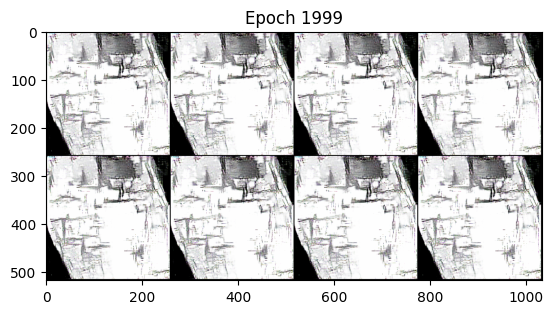

In [12]:
import matplotlib.pyplot as plt
import torchvision

def save_generated_images(epoch, generator, embed, noise_dim=100):
    generator.eval()  # Set to evaluation mode
    noise = torch.randn(8, noise_dim, device=device)  # Generate a small batch of random noise
    with torch.no_grad():  # Disable gradients for testing
        generated_images = generator(noise, embed).cpu() * 0.5 + 0.5  # Scale images to [0, 1]
    grid_img = torchvision.utils.make_grid(generated_images, nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(f"Epoch {epoch}")
    plt.show()

# Call this function at the end of each epoch
save_generated_images(epoch, generator, text_embeddings)

In [13]:
torch.save(generator.state_dict(), f"generator_epoch_{epoch}.pth")
torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")

In [ ]:
import os
import json
from PIL import Image
from torchvision import transforms

# Paths for images and JSON labels
image_folder = 'Images'                  # Folder with original images
json_folder = 'Labeled Image'             # Folder with original JSON labels
augmented_folder = 'Augmented_Images'     # Folder to save augmented images
augmented_json_folder = 'Augmented_Labels' # Folder to save JSON labels for augmented images

# Ensure output folders exist
os.makedirs(augmented_folder, exist_ok=True)
os.makedirs(augmented_json_folder, exist_ok=True)

# Define the augmentations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), ratio=(0.9, 1.1))
])

# Number of augmentations per original image
num_augmented_images_per_image = 5  # Adjust as needed

# Loop through each image and apply augmentations
for filename in os.listdir(image_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(image_folder, filename)
        img = Image.open(img_path)

        # Process corresponding JSON file if it exists
        json_filename = os.path.splitext(filename)[0] + '.json'
        json_path = os.path.join(json_folder, json_filename)
        if not os.path.exists(json_path):
            print(f"Warning: No JSON label found for {filename}")
            continue

        # Load original JSON data
        with open(json_path, 'r') as file:
            label_data = json.load(file)

        # Generate and save augmented images with labels
        for i in range(num_augmented_images_per_image):
            # Apply the augmentation
            augmented_img = augmentation(img)

            # Save the augmented image
            new_image_filename = f"{os.path.splitext(filename)[0]}_aug_{i}.png"
            augmented_img_path = os.path.join(augmented_folder, new_image_filename)
            augmented_img.save(augmented_img_path)
            print(f"Saved {augmented_img_path}")

            # Save the corresponding JSON label for augmented image
            new_json_filename = f"{os.path.splitext(json_filename)[0]}_aug_{i}.json"
            augmented_json_path = os.path.join(augmented_json_folder, new_json_filename)
            with open(augmented_json_path, 'w') as aug_file:
                json.dump(label_data, aug_file, indent=4)
            print(f"Saved {augmented_json_path}")

print("Data augmentation and JSON label duplication complete.")


Saved Augmented_Images\1_aug_0.png
Saved Augmented_Labels\1_aug_0.json
Saved Augmented_Images\1_aug_1.png
Saved Augmented_Labels\1_aug_1.json
Saved Augmented_Images\1_aug_2.png
Saved Augmented_Labels\1_aug_2.json
Saved Augmented_Images\1_aug_3.png
Saved Augmented_Labels\1_aug_3.json
Saved Augmented_Images\1_aug_4.png
Saved Augmented_Labels\1_aug_4.json
Saved Augmented_Images\10_aug_0.png
Saved Augmented_Labels\10_aug_0.json
Saved Augmented_Images\10_aug_1.png
Saved Augmented_Labels\10_aug_1.json
Saved Augmented_Images\10_aug_2.png
Saved Augmented_Labels\10_aug_2.json
Saved Augmented_Images\10_aug_3.png
Saved Augmented_Labels\10_aug_3.json
Saved Augmented_Images\10_aug_4.png
Saved Augmented_Labels\10_aug_4.json
Saved Augmented_Images\11_aug_0.png
Saved Augmented_Labels\11_aug_0.json
Saved Augmented_Images\11_aug_1.png
Saved Augmented_Labels\11_aug_1.json
Saved Augmented_Images\11_aug_2.png
Saved Augmented_Labels\11_aug_2.json
Saved Augmented_Images\11_aug_3.png
Saved Augmented_Labels\11

In [14]:
import torch
import clip
from PIL import Image
from torchvision import transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to calculate similarity
def calculate_similarity(description, generated_image):
    # Preprocess text
    text = clip.tokenize([description]).to(device)
    
    # Preprocess image
    generated_image = preprocess(generated_image).unsqueeze(0).to(device)
    
    # Extract features
    with torch.no_grad():
        image_features = model.encode_image(generated_image)
        text_features = model.encode_text(text)
    
    # Calculate cosine similarity
    similarity = torch.cosine_similarity(image_features, text_features).item()
    return similarity

# Test the function with generated image
def check_image_generation(generator, text_description):
    # Generate an image from text description
    generator.eval()
    with torch.no_grad():
        # Generate noise and embedding from description
        noise = torch.randn(1, noise_dim).to(device)  # Assuming noise_dim is defined
        text_embeddings = torch.randn(1, 768).to(device)  # Replace with actual text embedding
        gen_image = generator(noise, text_embeddings).cpu()

        # Convert tensor to PIL image
        gen_image = transforms.ToPILImage()(gen_image.squeeze())

    # Calculate similarity
    similarity_score = calculate_similarity(text_description, gen_image)
    print(f"Similarity Score for '{text_description}': {similarity_score:.4f}")

# Example usage
description = "a large living room with a couch and TV"
check_image_generation(generator, description)


100%|███████████████████████████████████████| 338M/338M [00:28<00:00, 12.2MiB/s]


Similarity Score for 'a large living room with a couch and TV': 0.1991


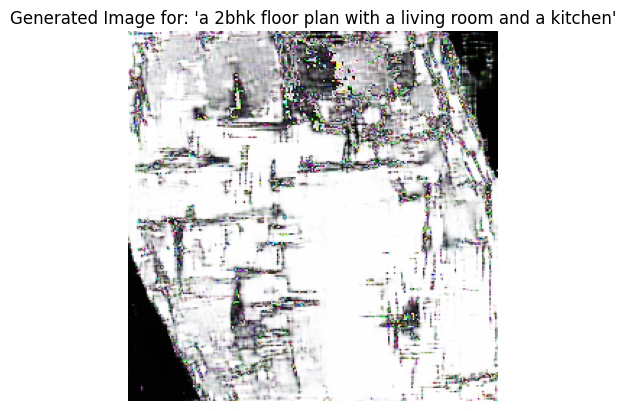

In [15]:
import torch
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get BERT embedding for a text description
def get_bert_embedding(description):
    inputs = tokenizer(description, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return text_embedding.unsqueeze(0)  # Shape: (1, embed_dim)

# Function to generate an image from a text description
def generate_image_from_text(generator, description, noise_dim=100):
    # Get BERT embedding
    text_embedding = get_bert_embedding(description)

    # Generate noise vector
    noise = torch.randn(1, noise_dim).to(device)

    # Generate the image with the GAN
    generator.eval()
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).cpu()

    # Convert tensor to PIL image
    generated_image = transforms.ToPILImage()(generated_image.squeeze())
    return generated_image

# Display the generated image
def display_generated_image(description):
    generated_image = generate_image_from_text(generator, description)
    plt.imshow(generated_image)
    plt.title(f"Generated Image for: '{description}'")
    plt.axis('off')
    plt.show()

# Example usage
description = "a 2bhk floor plan with a living room and a kitchen"
display_generated_image(description)


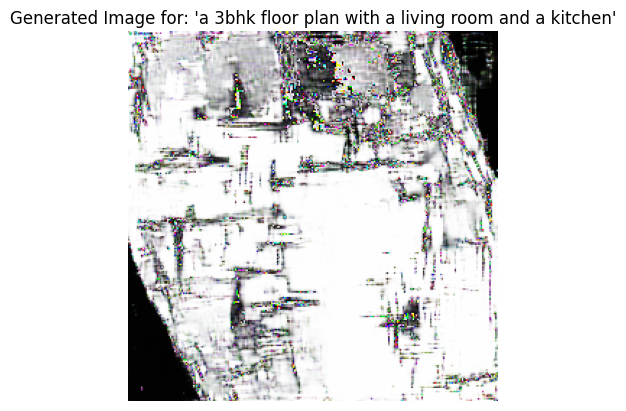

In [16]:
import torch
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get BERT embedding for a text description
def get_bert_embedding(description):
    inputs = tokenizer(description, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return text_embedding.unsqueeze(0)  # Shape: (1, embed_dim)

# Function to generate an image from a text description
def generate_image_from_text(generator, description, noise_dim=100):
    # Get BERT embedding
    text_embedding = get_bert_embedding(description)

    # Generate noise vector
    noise = torch.randn(1, noise_dim).to(device)

    # Generate the image with the GAN
    generator.eval()
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).cpu()

    # Convert tensor to PIL image
    generated_image = transforms.ToPILImage()(generated_image.squeeze())
    return generated_image

# Display the generated image
def display_generated_image(description):
    generated_image = generate_image_from_text(generator, description)
    plt.imshow(generated_image)
    plt.title(f"Generated Image for: '{description}'")
    plt.axis('off')
    plt.show()

# Example usage
description = "a 3bhk floor plan with a living room and a kitchen"
display_generated_image(description)


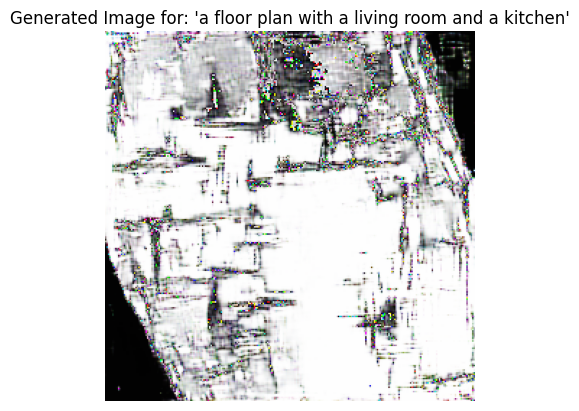

In [18]:
import torch
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get BERT embedding for a text description
def get_bert_embedding(description):
    inputs = tokenizer(description, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return text_embedding.unsqueeze(0)  # Shape: (1, embed_dim)

# Function to generate an image from a text description
def generate_image_from_text(generator, description, noise_dim=100):
    # Get BERT embedding
    text_embedding = get_bert_embedding(description)

    # Generate noise vector
    noise = torch.randn(1, noise_dim).to(device)

    # Generate the image with the GAN
    generator.eval()
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).cpu()

    # Convert tensor to PIL image
    generated_image = transforms.ToPILImage()(generated_image.squeeze())
    return generated_image

# Display the generated image
def display_generated_image(description):
    generated_image = generate_image_from_text(generator, description)
    plt.imshow(generated_image)
    plt.title(f"Generated Image for: '{description}'")
    plt.axis('off')
    plt.show()

# Example usage
description = "a floor plan with a living room and a kitchen"
display_generated_image(description)


In [19]:
import torch
import clip
from PIL import Image
from torchvision import transforms

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function to calculate similarity
def calculate_similarity(description, generated_image):
    # Preprocess text
    text = clip.tokenize([description]).to(device)
    
    # Preprocess image
    generated_image = preprocess(generated_image).unsqueeze(0).to(device)
    
    # Extract features
    with torch.no_grad():
        image_features = model.encode_image(generated_image)
        text_features = model.encode_text(text)
    
    # Calculate cosine similarity
    similarity = torch.cosine_similarity(image_features, text_features).item()
    return similarity

# Test the function with generated image
def check_image_generation(generator, text_description):
    # Generate an image from text description
    generator.eval()
    with torch.no_grad():
        # Generate noise and embedding from description
        noise = torch.randn(1, noise_dim).to(device)  # Assuming noise_dim is defined
        text_embeddings = torch.randn(1, 768).to(device)  # Replace with actual text embedding
        gen_image = generator(noise, text_embeddings).cpu()

        # Convert tensor to PIL image
        gen_image = transforms.ToPILImage()(gen_image.squeeze())

    # Calculate similarity
    similarity_score = calculate_similarity(text_description, gen_image)
    print(f"Similarity Score for '{text_description}': {similarity_score:.4f}")

# Example usage
description = "a large living room with a couch and TV"
check_image_generation(generator, description)


Similarity Score for 'a large living room with a couch and TV': 0.2010


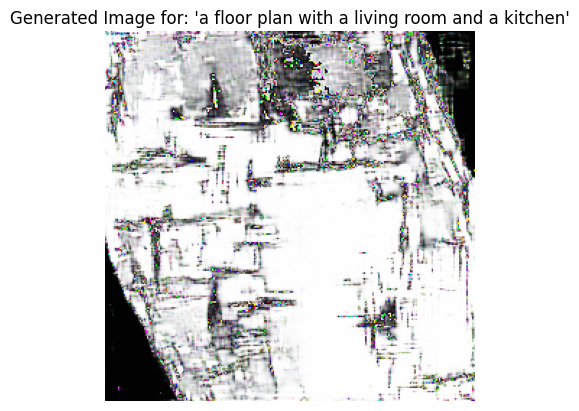

Image saved as floor_plan_image.png


In [21]:
import torch
from transformers import BertTokenizer, BertModel
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to get BERT embedding for a text description
def get_bert_embedding(description):
    inputs = tokenizer(description, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token embedding as the sentence embedding
    text_embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return text_embedding.unsqueeze(0)  # Shape: (1, embed_dim)

# Function to generate an image from a text description
def generate_image_from_text(generator, description, noise_dim=100):
    # Get BERT embedding
    text_embedding = get_bert_embedding(description)

    # Generate noise vector
    noise = torch.randn(1, noise_dim).to(device)

    # Generate the image with the GAN
    generator.eval()
    with torch.no_grad():
        generated_image = generator(noise, text_embedding).cpu()

    # Convert tensor to PIL image
    generated_image = transforms.ToPILImage()(generated_image.squeeze())
    return generated_image

# Function to display and save the generated image
def display_and_save_generated_image(description, filename="generated_image.png"):
    generated_image = generate_image_from_text(generator, description)

    # Display the generated image
    plt.imshow(generated_image)
    plt.title(f"Generated Image for: '{description}'")
    plt.axis('off')
    plt.show()

    # Save the generated image
    generated_image.save(filename)
    print(f"Image saved as {filename}")

# Example usage
description = "a floor plan with a living room and a kitchen"
display_and_save_generated_image(description, "floor_plan_image.png")
